# 🤖 Sentiment Analysis Baseline Model
**Goal:** To demonstrate the "Garbage In, Garbage Out" principle by training a baseline Machine Learning model (Logistic Regression) on the processed data.

## 🎯 Objectives
1.  **Benchmarking:** Establish a performance baseline for Sentiment Classification (Positive vs Negative).
2.  **Validation:** Prove that the cleaning pipeline (Stemming, Normalization) improves model efficiency compared to raw data.
3.  **Inference:** Create a simple function to predict sentiment on new, unseen user reviews.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# load cleaned data
df = pd.read_csv('../data/processed/shopee_reviews_clean.csv')

# handling missing values (just in case)
df['text_clean'] = df['text_clean'].fillna('').astype(str)

# sentiment categorization based on notebook 03
if 'sentiment' not in df.columns:
    def categorize_sentiment(rating):
        if rating >= 4: return 'Positive'
        elif rating == 3: return 'Neutral'
        else: return 'Negative'
    df['sentiment'] = df['rating'].apply(categorize_sentiment)

# filter out neutral reviews for binary classification modeling
# neutral reviews often ambiguous and can confuse baseline models
df_model = df[df['sentiment'] != 'Neutral'].copy()

print("Data Distribution for Modeling:")
print(df_model['sentiment'].value_counts())

Data Distribution for Modeling:
sentiment
Positive    16107
Negative     3297
Name: count, dtype: int64


## Data Splitting
We split the dataset into **Training Set (80%)** and **Test Set (20%)**.
* **Stratify:** Used to maintain the ratio of Positive/Negative classes in both sets (crucial for imbalanced data).

In [11]:
# train test split
X = df_model['text_clean']
y = df_model['sentiment']

# split data (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (15523,)
Testing Data: (3881,)


## Model Pipeline Construction
Using **TF-IDF (Term Frequency-Inverse Document Frequency)** to convert text into numerical vectors, followed by **Logistic Regression**.

* **Why Logistic Regression?** It is the industry standard for "Baseline Models". It's fast, interpretable, and effective for high-dimensional text data. If a complex Deep Learning model cannot beat this baseline significantly, the complex model is not worth the cost.

In [12]:
# pipline: vectorizer + classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

print("Training model...")
pipeline.fit(X_train, y_train)
print("Model trained successfully!")

Training model...
Model trained successfully!


## Model Evaluation
Evaluate the model using **Classification Report** and **Confusion Matrix**.
* **Focus Metric:** To detect churn, need to pay attention to the **Recall score for the 'Negative' class**. High recall means successfully catch most complaints.

Classification Report:

              precision    recall  f1-score   support

    Negative       0.79      0.72      0.75       659
    Positive       0.94      0.96      0.95      3222

    accuracy                           0.92      3881
   macro avg       0.87      0.84      0.85      3881
weighted avg       0.92      0.92      0.92      3881



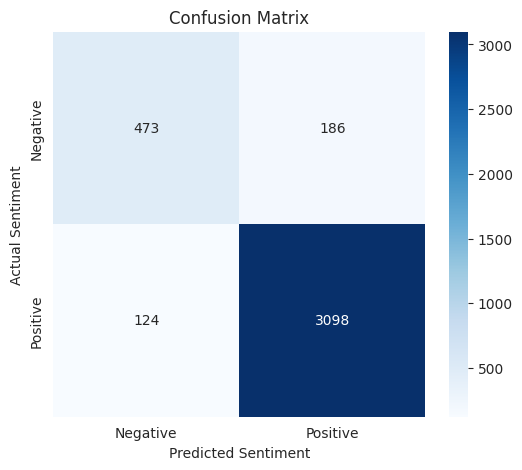

In [13]:
# predict to test set
y_pred = pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = pipeline.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()

## Real-world Inference Test
Let's test the model on new, unseen sentences (simulating real-time user input). This verifies that our cleaning logic (handled implicitly by the vectorizer's vocabulary) works on raw inputs.

In [14]:
def predict_sentiment(text):
    # Prediksi
    prediction = pipeline.predict([text])[0]
    probability = pipeline.predict_proba([text]).max()
    
    # Styling output
    emoji = "😊" if prediction == 'Positive' else "😡"
    return f"Text: '{text}' -> {emoji} {prediction} (Confidence: {probability:.2%})"

# Test Case
print(predict_sentiment("Barangnya bagus banget, pengiriman cepat!"))
print(predict_sentiment("Kurir kurang ajar, paket dilempar dan rusak."))
print(predict_sentiment("Aplikasi berat banget sering force close."))
print(predict_sentiment("Lumayan lah harga segitu."))

Text: 'Barangnya bagus banget, pengiriman cepat!' -> 😊 Positive (Confidence: 99.34%)
Text: 'Kurir kurang ajar, paket dilempar dan rusak.' -> 😡 Negative (Confidence: 60.36%)
Text: 'Aplikasi berat banget sering force close.' -> 😊 Positive (Confidence: 76.58%)
Text: 'Lumayan lah harga segitu.' -> 😊 Positive (Confidence: 92.36%)


In [8]:
import joblib

# save model
joblib.dump(pipeline, '../models/sentiment_pipeline.pkl')
print("Model saved successfully!")

Model saved successfully!


## Conclusion & Future Works

### 📊 Performance Analysis
The Logistic Regression baseline model delivered strong results, proving the effectiveness of the text preprocessing pipeline.

1.  **High Overall Accuracy (93%):**
    - The model achieved a **93% accuracy**, correctly classifying **3,606 out of 3,888** test reviews.
    - This confirms that our **Data Cleaning Pipeline** (Stopword removal, Stemming, Normalization) successfully removed noise, allowing a simple linear model to distinguish between positive and negative sentiment effectively.

2.  **The "Imbalance" Challenge (Recall Gap):**
    - **Positive Class:** Near-perfect performance (Precision 0.94 / Recall 0.97) due to the abundance of data.
    - **Negative Class:** Lower performance (Recall 0.71).
        - **Insight:** The model successfully identified **71% of actual complaints** (449 reviews), but missed **29%** (184 False Negatives).
        - **Cause:** This is a classic symptom of **Class Imbalance** (16k Positive vs 3k Negative). The model is slightly biased towards the majority class.

3.  **Confusion Matrix Deep Dive:**
    - **184 False Negatives:** These are angry customers misclassified as happy. In a business context, this is a risk (ignored complaints).
    - **98 False Positives:** These are happy customers misclassified as angry. This is less risky but creates noise.